In [ ]:
#Quick cell to make jupyter notebook use the full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE 
output_notebook(resources=INLINE)

In [ ]:
from src import workflow
from src.data import Dataset
from src import paths

In [ ]:
import umap
import umap.plot
from vectorizers import NgramVectorizer
import numpy as np

## First step of the embedding: Vectorization

We are going to vectorize our data and look at the number of categorical values they have in common.  

In [ ]:
beer_style_dset = Dataset.load("beer_style_reviewers")
beer_style_dset.metadata

In [ ]:
beer_style = beer_style_dset.data
beer_style.review_profilename_list[:5]

This step turns the list of reviewers into a sparse matrix of counts. One row per row of our data frame and one column per unique token that appeared in our categorical field of interest.



If we think counts should matter we could use:<BR>
`beer_by_authors_vectorizer = NgramVectorizer()`<BR>
    
We use `min_document_occurrences=10` in our NgramVectorizer to only count reviewers who have reviewed at least 10 beers. Here a *document* corresponds to a *beer_style*. 

In [ ]:
beer_by_authors_vectorizer = NgramVectorizer(min_document_occurrences=10)

In [ ]:
matrix = beer_by_authors_vectorizer.fit_transform(beer_style.review_profilename_list)

In [ ]:
matrix

We want to deal with reviewers as sets (i.e. just presence or absence of a category), so we will binarize the matrix. Since we already treated the list of reviwers per beer style as a set (by making each list element unique) binarizing the matrix is redundant...but we'll do it to illustrate the technique, and double-check our result.

In [ ]:
style_by_authors = (matrix != 0).astype(np.float32)

In [ ]:
style_by_authors != matrix

This results in an impractically large vector space. We want an embedding into a much smaller space. 

Now we reduce the dimension of this data.

If we are dealing with sets (i.e. just presence or absence of a category) use:<BR>
`metric='jaccard'`<BR>
If we think counts should matter we might use:<BR>
`metric='hellinger'`<BR>
or if we want to correct for very unbalanced column frequencies:<BR>
`metric='hellinger'`<BR>
    
As you get more and more points I'd recommend increasing the `n_neighbors` parameter to compensate.  Think of this as a resolution parameter.

`n_components` controls the dimension you will be embedding your data into (2-dimensions for easy visualization).  Feel free to embed into higher dimensions for clustering if you'd like.

`unique=True` says that if you have two identical points you want to map them to the exact same co-ordinates in your low space.  This becomes especially important if you have more exact dupes that your `n_neighbors` parameter.  That is the problem case where exact dupes can be pushed into very different regions of your space.

In [ ]:
%%time
style_by_authors_model = umap.UMAP(n_neighbors=5, n_components=2, metric='jaccard', min_dist=0.1,
                                  unique=True, random_state=42).fit(style_by_authors.todense())

In [ ]:
np.log(beer_style.num_reviewers).describe()

In [ ]:
path_to_figures = paths['project_path'] / 'reports' / 'figures'
root_filename = 'beer_style_by_reviewer_jaccard'
outfile_png = path_to_figures / (root_filename + '.png')
outfile_html = path_to_figures / (root_filename + '.html')

In [ ]:
umap_plot = umap.plot.points(style_by_authors_model, labels=np.log(beer_style.num_reviewers), theme='fire', show_legend=False);
#umap_plot.figure.savefig(outfile_png, dpi=300, bbox_inches='tight')

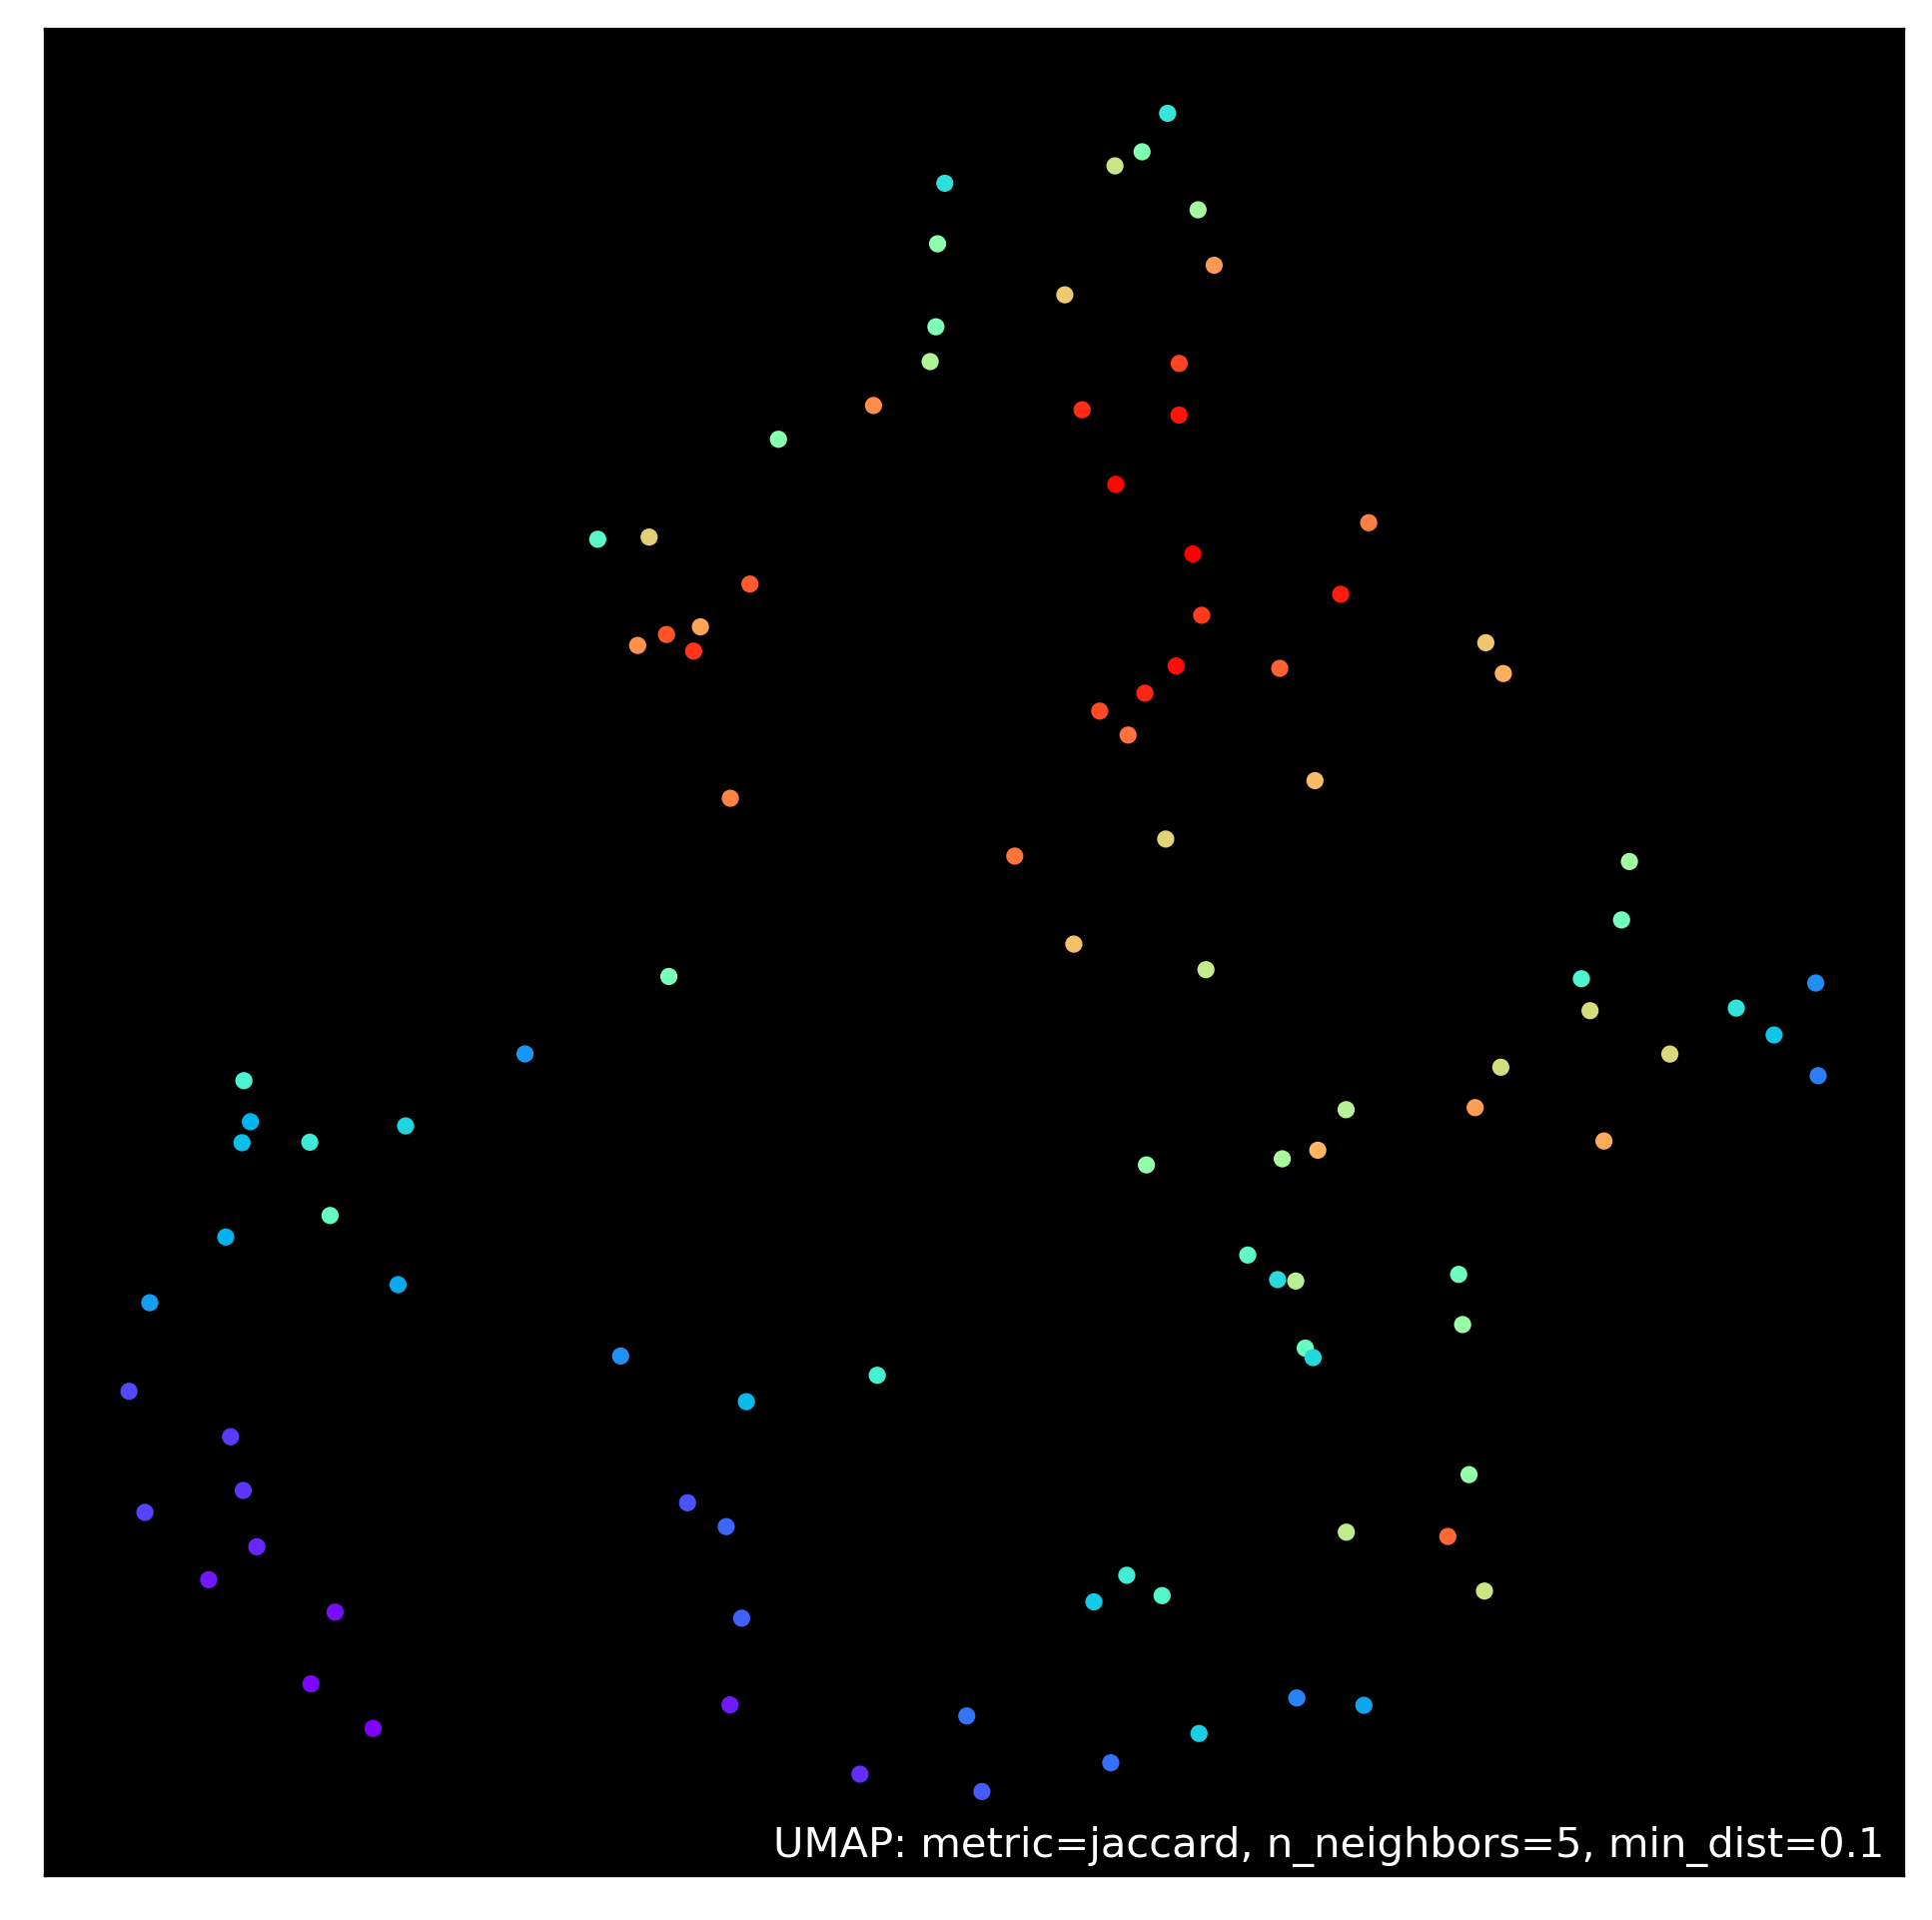

... and now for an interactive plot with mouseover.

In [ ]:
hover_df = beer_style['beer_style beer_abv num_reviewers review_overall brewery_name'.split()]
f = umap.plot.interactive(style_by_authors_model, labels=np.log(beer_style.num_reviewers), 
                          hover_data=hover_df, theme='fire', point_size=5);
#save(f, filename=outfile_html)
show(f)